## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC



from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler




**QUESTION:** Load dataset and display some lines of the csv file.

In [3]:
data_path = "/content/ai4i2020.csv"


df = pd.read_csv(data_path)


df.head()



,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

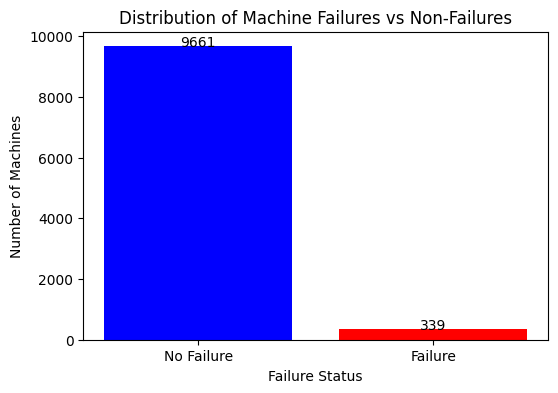

In [4]:

if 'Machine failure' in df.columns:
    counts_machine_failure = df['Machine failure'].value_counts()


    labels = ['No Failure', 'Failure']
    values = [counts_machine_failure.get(0, 0), counts_machine_failure.get(1, 0)]


    plt.figure(figsize=(6, 4))
    plt.bar(labels, values, color=['blue', 'red'])
    plt.title("Distribution of Machine Failures vs Non-Failures")
    plt.xlabel("Failure Status")
    plt.ylabel("Number of Machines")


    for i, v in enumerate(values):
        plt.text(i, v + 0.5, str(int(v)), ha='center')

    plt.show()
else:
    print("A coluna 'Machine failure' não foi encontrada no dataset.")


**ANALYSIS QUESTION:** What do you observe?

Há muitas maquinas que não houveram falhas em compararação com máquinas que tiveram falhas.



**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

Porteriormente ao usar esses dados para treinar a IA, pode acarretar em um bom aprendizado para detectar apenas quando não há falhas, resultando em mal aprendizado para identificar quando há falhas também.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

<ipython-input-5-235485598937>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=failure_counts.index, y=failure_counts.values, palette=['blue', 'orange', 'green', 'red', 'purple'] )


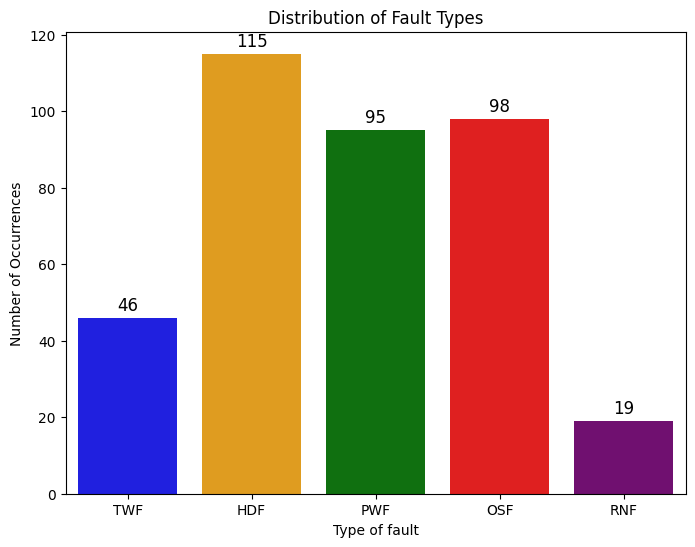

In [5]:
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = df[failure_types].sum()

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=failure_counts.index, y=failure_counts.values, palette=['blue', 'orange', 'green', 'red', 'purple'] )

for i, value in enumerate(failure_counts.values):
    ax.text(i, value + 2, str(value), ha='center', fontsize=12)

plt.xlabel("Type of fault")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Fault Types")

plt.show()

**ANALYSIS QUESTION:** What do you observe?

Mesmo em comparação com as maquinas que tiveram falhas, ainda sim há um diferença entre os tipos de falhas, onde 19 foram categorizadas como RNF e 115 foram caracterizadas como HDF.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

<ipython-input-6-708757154ff1>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=failure_counts.index, y=failure_counts.values,  palette=['blue', 'orange', 'green', 'red', 'purple', 'gray'])


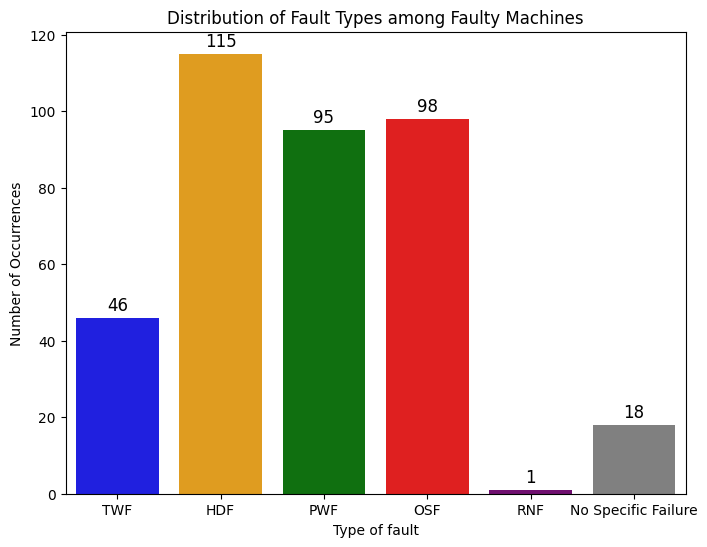

In [6]:
failed_machines = df[df["Machine failure"] == 1]

failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = failed_machines[failure_types].sum()

no_specific_failure = df[(df["Machine failure"] == 0) & (df["RNF"] == 1)].shape[0]

failure_counts["No Specific Failure"] = no_specific_failure

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=failure_counts.index, y=failure_counts.values,  palette=['blue', 'orange', 'green', 'red', 'purple', 'gray'])

for i, value in enumerate(failure_counts.values):
    ax.text(i, value + 2, str(value), ha='center', fontsize=12)

plt.xlabel("Type of fault")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Fault Types among Faulty Machines")

plt.show()

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

Mais uma vez há uma discrepancia no número de amostras nas maquinás que obtiveram falhas, onde apenas 1 foi caracterizada como RNF e 115 como HDF

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [ ]:
print("Column Names and Data Types:")
print(df.dtypes)

Column Names and Data Types:
UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

Para treinar o modelo, as entradas escolhidas serão as variáveis que indicam o uso da máquina e situação fisica dela, como Air temperature, Process temperature, Rotational speed, Torque, Tool wear e Type, pois influenciam diretamente no desempenho e possíveis falhas. As saídas
serão Machine failure e as colunas com os tipos de falhas como TWF, HDF, PWF, OSF e RNF. Isso acarreta em uma previsão sobre os possiveis problemas além de permitir ações de manutenção preditiva baseadas nas condições da máquina.

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [7]:
# Criar variáveis dummies para a coluna 'Type'
df = pd.get_dummies(df, columns=['Type'], drop_first=False)


In [8]:
# Definir X (remover IDs e variáveis de saída)
X = df.drop(columns=['UDI', 'Product ID', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])

# Definir y (agora multi-label: cada falha é independente)
Y = df[['Machine failure','TWF', 'HDF', 'PWF', 'OSF']]

# Criar coluna "No Failure"
#Y['No Failure'] = (df['Machine failure'] == 0).astype(int)

# Normalizar X para intervalo [0,1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# print das colunas de x e y
print(X.head())
print(Y.head())
# Divisão treino (70%) e teste (30%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Exibir dimensões
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0             0.304348                 0.358025                0.222934   
1             0.315217                 0.370370                0.139697   
2             0.304348                 0.345679                0.192084   
3             0.315217                 0.358025                0.154249   
4             0.315217                 0.370370                0.139697   

   Torque [Nm]  Tool wear [min]  Type_H  Type_L  Type_M  
0     0.535714         0.000000     0.0     0.0     1.0  
1     0.583791         0.011858     0.0     1.0     0.0  
2     0.626374         0.019763     0.0     1.0     0.0  
3     0.490385         0.027668     0.0     1.0     0.0  
4     0.497253         0.035573     0.0     1.0     0.0  
   Machine failure  TWF  HDF  PWF  OSF
0                0    0    0    0    0
1                0    0    0    0    0
2                0    0    0    0    0
3                0    0    0    0    0
4     





**QUESTION** Code below the model architecture

In [9]:

# Criar o modelo aprimorado para multi-label
model = Sequential([
    Dense(256, kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),

    Dense(128, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.2),

    Dense(64, kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.2),

    Dense(32, kernel_regularizer=l2(0.005)),
    LeakyReLU(),

    Dense(5, activation='sigmoid')  # 5 classes: Machine Failure, TWF, HDF, PWF, OSF
])

# Compilar o modelo com métricas ajustadas
model.compile(optimizer=AdamW(learning_rate=0.0005, weight_decay=0.01),
              loss='binary_crossentropy',  # Multi-label classification
              metrics=['binary_accuracy', AUC(name='auc')])

# Exibir resumo
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,493 (185.52 KB)

 Trainable params: 46,597 (182.02 KB)

 Non-trainable params: 896 (3.50 KB)

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - auc: 0.5783 - binary_accuracy: 0.8227 - loss: 2.5456 - val_auc: 0.5737 - val_binary_accuracy: 0.9873 - val_loss: 1.4415 - learning_rate: 5.0000e-04
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc: 0.7448 - binary_accuracy: 0.9863 - loss: 0.9783 - val_auc: 0.6078 - val_binary_accuracy: 0.9873 - val_loss: 0.6384 - learning_rate: 5.0000e-04
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc: 0.8195 - binary_accuracy: 0.9870 - loss: 0.4397 - val_auc: 0.6366 - val_binary_accuracy: 0.9873 - val_loss: 0.3425 - learning_rate: 5.0000e-04
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc: 0.8531 - binary_accuracy: 0.9851 - loss: 0.2565 - val_auc: 0.6449 - val_binary_accuracy: 0.9873 - val_loss: 0.2213 - learning_rate: 5.0000e-04
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8939 - binary_accuracy: 0.9852 - loss: 0.1724 - val_auc: 0.7335 - val_binary_accuracy: 0.9873 - val_loss: 0.1655 - learning_rate: 

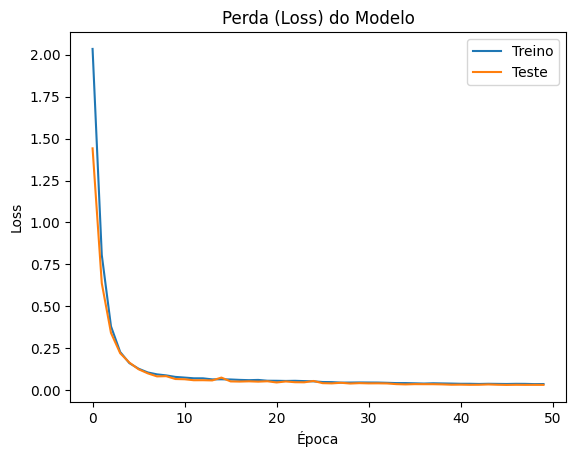

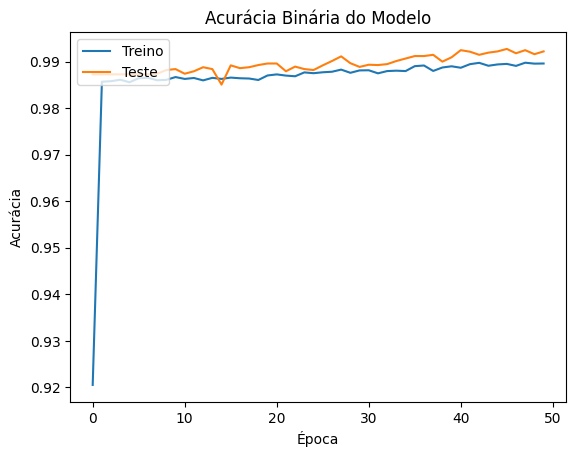

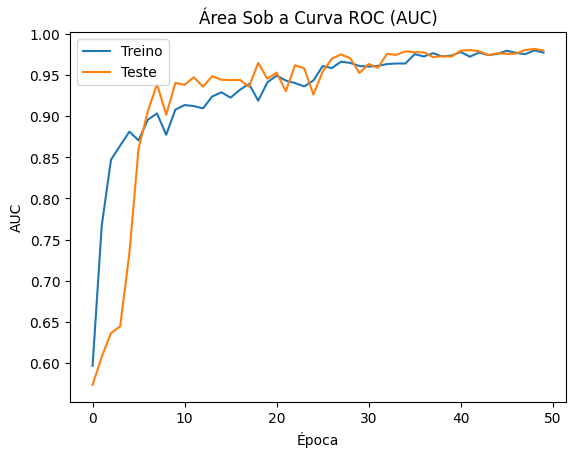

In [10]:


# Definir callbacks otimizados
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)

# Treinar modelo
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

#Função para plotar métricas corretamente para multi-label
def plot_metric(history, metric, title, ylabel, loc='upper left'):
    if metric in history.history:
        plt.plot(history.history[metric], label='Treino')
    if f'val_{metric}' in history.history:
        plt.plot(history.history[f'val_{metric}'], label='Teste')

    plt.title(title)
    plt.xlabel('Época')
    plt.ylabel(ylabel)
    plt.legend(loc=loc)
    plt.show()

#Plotar a perda (loss)
plot_metric(history, 'loss', 'Perda (Loss) do Modelo', 'Loss', loc='upper right')

#  Plotar acurácia binária (para multi-label)
plot_metric(history, 'binary_accuracy', 'Acurácia Binária do Modelo', 'Acurácia')

#  Plotar AUC (Área Sob a Curva ROC)
plot_metric(history, 'auc', 'Área Sob a Curva ROC (AUC)', 'AUC')


**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Relatório de Classificação:
                 precision    recall  f1-score   support

Machine Failure       0.80      0.52      0.63        93
            TWF       0.00      0.00      0.00        14
            HDF       1.00      0.28      0.44        25
            PWF       0.96      0.71      0.81        31
            OSF       0.95      0.68      0.79        28

      micro avg       0.87      0.50      0.64       191
      macro avg       0.74      0.44      0.53       191
   weighted avg       0.81      0.50      0.61       191
    samples avg       0.02      0.02      0.02       191



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

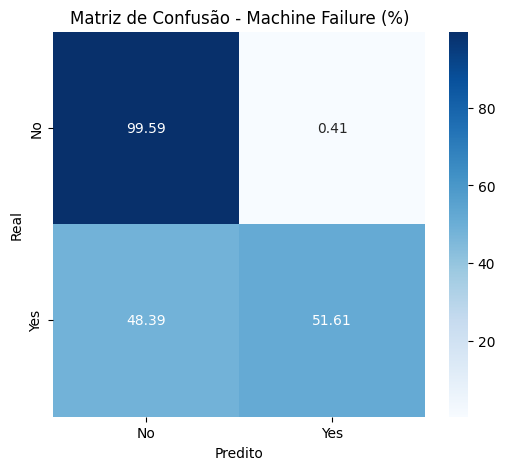

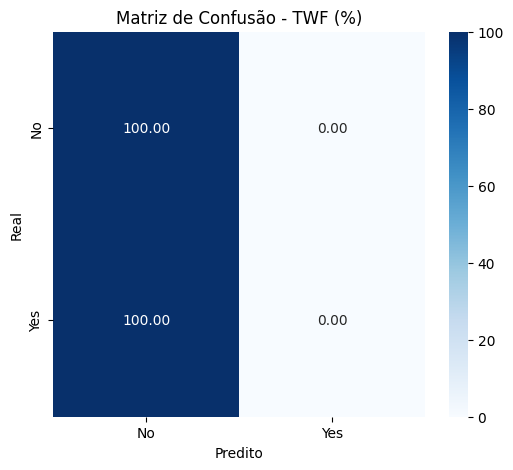

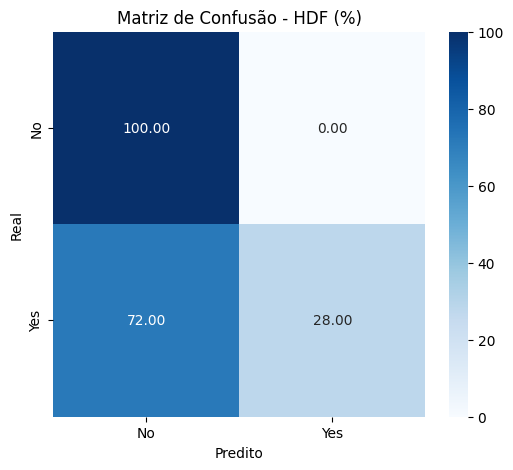

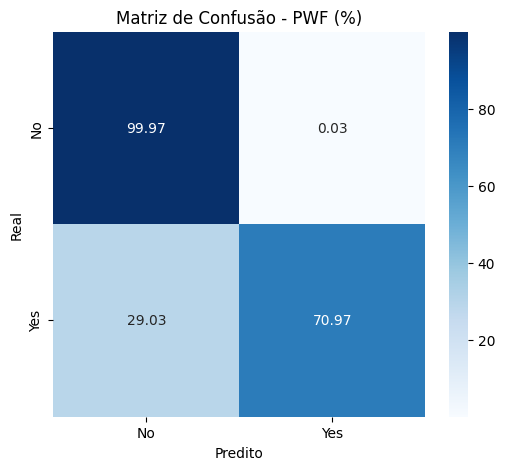

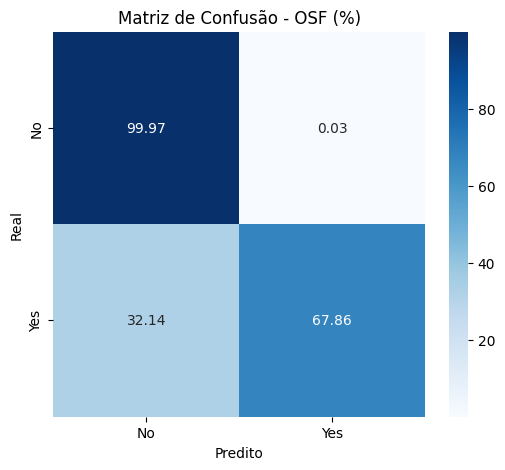

In [11]:

# Fazer previsões (probabilidades)
Y_pred_probs = model.predict(X_test)

# Converter probabilidades para 0 ou 1 (threshold = 0.5)
Y_pred = (Y_pred_probs >= 0.5).astype(int)

# Gerar relatório detalhado de precisão, recall e F1-score
report = classification_report(Y_test, Y_pred, target_names=['Machine Failure', 'TWF', 'HDF', 'PWF', 'OSF'])

# Exibir relatório
print("\nRelatório de Classificação:")
print(report)

# Criar matrizes de confusão separadas para cada classe (em porcentagem)
labels = ['Machine Failure', 'TWF', 'HDF', 'PWF', 'OSF']
cm_matrices = multilabel_confusion_matrix(Y_test, Y_pred)

# Criar plots separados para cada matriz de confusão
for i, label in enumerate(labels):
    cm = cm_matrices[i].astype('float') / cm_matrices[i].sum(axis=1, keepdims=True) * 100  # Normalizar para porcentagem

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"Matriz de Confusão - {label} (%)")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()


**ANALYSIS QUESTION** What do you observe? What can you conclude?

O modelo ficou bom em prever quando não há falhas, porém ele não consegue prever quando há, e sempre a respota que prevalece é que não houve, dado que o numero de maquinas sem falhas é muito maior em comparação com as maquinas com falhas.

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Inicializar DataFrames vazios para armazenar os novos dados balanceados
X_resampled = []
y_resampled = []

# Aplicar SMOTE separadamente para cada classe binária
for col in Y_train.columns:
    smote = SMOTE(sampling_strategy=0.2, random_state=42)  # Ajuste a estratégia conforme necessário
    X_tmp, y_tmp = smote.fit_resample(X_train, Y_train[col])  # Balanceia apenas para a coluna atual

    X_resampled.append(X_tmp)
    y_resampled.append(y_tmp)

# Combinar os novos dados em um único conjunto balanceado
X_train_balanced_smote = pd.concat(X_resampled).reset_index(drop=True)
Y_train_balanced_smote = pd.concat(y_resampled, axis=1).reset_index(drop=True)

# Exibir nova distribuição das classes
print("\nDistribuição das classes após SMOTE:")
print(Y_train_balanced_smote.sum())



Distribuição das classes após SMOTE:
TWF                1393.0
HDF                1382.0
PWF                1387.0
OSF                1386.0
Machine failure    1350.0
No Failure         6754.0
dtype: float64


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

Eu fiz a mistura de SMOTE e class weigths, pois com o SMOTE, consigo criar novas amostras das Maquinas com Falhas, enquanto que o classh weigths me permite modificar os pesos das variaveis de treino, assim consigo dar mais peso para as variaveis em menor numero e menor peso para as variaveis abundantes.

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [ ]:
# Criar o modelo de rede neural atualizado
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train_balanced_smote.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(6, activation='sigmoid')  # 5 saídas: TWF, HDF, PWF, OSF, Machine Failure
])

# Compilar o modelo
model.compile(optimizer=AdamW(learning_rate=0.0001, weight_decay=0.02),
              loss='binary_crossentropy',  # Classificação multi-rótulo
              metrics=['accuracy'])

# Exibir resumo do modelo
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_56 (Dense)                     │ (None, 128)                 │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,454 (48.65 KB)

 Trainable params: 12,070 (47.15 KB)

 Non-trainable params: 384 (1.50 KB)

**QUESTION** Code below the algorithms allowing to train model


In [ ]:

# Treinamento do modelo com SMOTE + Class Weights

history = model.fit(
    X_train_balanced_smote,
    Y_train_balanced_smote,
    validation_data=(X_test, Y_test),
    epochs=20,       # Número de épocas ajustável
    batch_size=16,   # Lote de treinamento ajustável
    #class_weight=class_weights_dict_smote,  # Aplicando pesos calculados
    verbose=1
)


# Plotando a Acurácia do Treino/Teste

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()


# Plotando o Loss do Treino/Teste

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perda (Loss) do Modelo')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend(['Treino', 'Teste'], loc='upper right')
plt.show()


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 49500
'y' sizes: 8361


**QUESTION** Plot the confusion matrix and the classification report

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


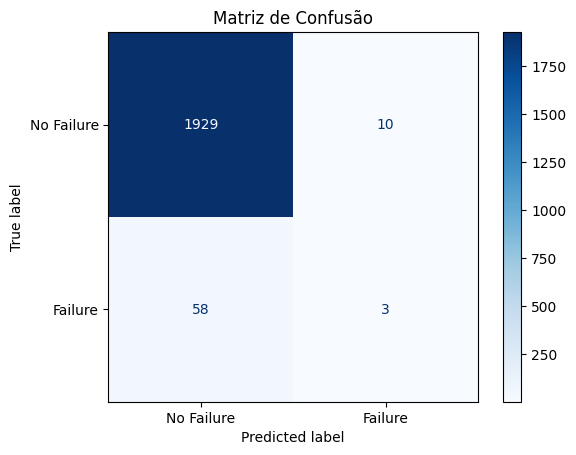


Relatório de Classificação:
              precision    recall  f1-score   support

  No Failure       0.97      0.99      0.98      1939
     Failure       0.23      0.05      0.08        61

    accuracy                           0.97      2000
   macro avg       0.60      0.52      0.53      2000
weighted avg       0.95      0.97      0.96      2000



In [ ]:

Y_pred_probs = model.predict(X_test)
threshold = 0.4 # Ajuste
Y_pred = (Y_pred_probs > threshold).astype(int)

cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Failure', 'Failure'])
disp.plot(values_format='d', cmap='Blues')
plt.title("Matriz de Confusão")
plt.show()

print("\nRelatório de Classificação:")
print(classification_report(Y_test, Y_pred, target_names=['No Failure', 'Failure']))


**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"